<a href="https://colab.research.google.com/github/neuralresearch/CS39-6/blob/keyuanren/HenryTaGSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Preparation

###Data Loading and observation

In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#get the data from the drive
id = '1E07PMf68jMo-rULzHfE_q7chqgaYGsXp'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AIDS700.zip')
!ls

AIDS700.zip  sample_data


In [ ]:
#if AIDS700nef exist do not run this part
#removing the dialog
%%capture
#unzip the file
!unzip AIDS700.zip

In [ ]:
#visualise the first network data: 1011.gexf
import networkx as nx
import matplotlib.pyplot as plt
import random

#read the 1011.gexf
Graph = nx.read_gexf('AIDS700nef/train/4.gexf',version='1.2draft')


In [ ]:
Graph.edges.data()
edgesdict={}
for n1,n2,attr in Graph.edges.data():
  edgesdict[(n1,n2)]=attr['valence']
edgesdict

{('7', '3'): 2,
 ('3', '1'): 1,
 ('3', '8'): 2,
 ('3', '9'): 1,
 ('5', '2'): 2,
 ('6', '2'): 1,
 ('1', '0'): 1,
 ('0', '2'): 1,
 ('4', '2'): 2}

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

G=Graph
def draw_graph(G):
  pos=nx.spring_layout(G ,seed=42,scale=2)
  edgelist=G.edges
  edge_labels = nx.get_edge_attributes(G, "valence")
  node_labels = nx.get_node_attributes(G, "type")

  nx.draw_networkx_nodes(G, pos, node_size=700)
  nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=6)
  nx.draw_networkx_labels(G, pos,labels=node_labels, font_size=20, font_family="sans-serif")
  nx.draw_networkx_edge_labels(G, pos, edge_labels)
def draw_graph_id(G):
  pos=nx.spring_layout(G ,seed=42,scale=2)
  edgelist=G.edges
  edge_labels = nx.get_edge_attributes(G, "valence")

  nx.draw_networkx_nodes(G, pos, node_size=700)
  nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=6)
  nx.draw_networkx_labels(G, pos,  font_size=20, font_family="sans-serif")
  nx.draw_networkx_edge_labels(G, pos, edge_labels)


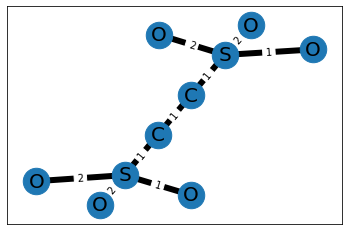

In [ ]:
draw_graph(G)

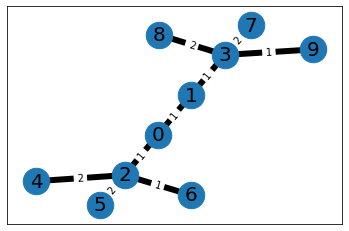

In [ ]:
draw_graph_id(G)

### Graph Pair Generator

{'NR': 1, 'NID': 1, 'ER': 1, 'EID': 3}


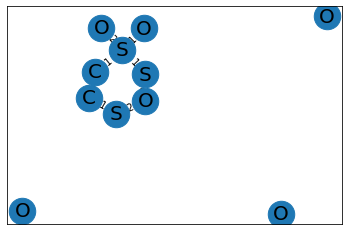

In [ ]:


def graphPairGenerator(Graph,targetGEV):
  NR=targetGEV['NR']
  NID=targetGEV['NID']
  ER=targetGEV['ER']
  EID=targetGEV['EID']
  
  GEVsum=NR+NID+ER+EID

  nodeList= list(Graph.nodes)
  edgeList= list(Graph.edges)

  # set limit of relabeling
  NodeDataView=Graph.nodes.data()
  if NR>len(nodeList):
    NR=len(nodeList)
  EdgeView=Graph.edges 
  if ER>len(edgeList):
    ER=len(edgeList)


  newGraph=Graph.copy()
  nodeLabels=set(nx.get_node_attributes(newGraph, "type").values())
  #print(nodeLabels)
  if len(nodeLabels)==1:
    nodeLabels.add('C')
    nodeLabels.add('S')
  #print(nodeLabels)
  edgeLabels=set(nx.get_edge_attributes(newGraph, "valence").values())
  if len(edgeLabels)==1:
    edgeLabels.add('1')
    edgeLabels.add('2')
  retryLimit=100
  def NodeRelabel(newGraph,NR):
    relabedNode=[]

    relabelDict={}

    if len(list(newGraph.nodes))==0:
      return newGraph,0

    for i in range(NR):
      nodeToBeRebel=random.choice(list(newGraph.nodes))
      retry=0
      while(nodeToBeRebel in relabedNode ):
        nodeToBeRebel=random.choice(list(newGraph.nodes))
        retry=retry+1
        if (retry>retryLimit):
          return  newGraph,i
      relabedNode.append(nodeToBeRebel)

      relabelDict[nodeToBeRebel]={}
      newLabel=random.choice(list(nodeLabels))
      retry=0
      while(newLabel ==NodeDataView[nodeToBeRebel]["type"] ):
        newLabel=random.choice(list(nodeLabels))
        retry=retry+1
        if (retry>retryLimit):
          return  newGraph,i
      relabelDict[nodeToBeRebel]['type']=newLabel
    nx.set_node_attributes(newGraph, relabelDict)
    #print('Relabel node list:',relabelDict)
    return newGraph,NR

  def NodeInserted(newGraph,NID):
    newNode=[]
    for i in range(NID):
      label=random.choice(list(nodeLabels))
      newGraph.add_node(i+len(nodeList),type=label)
      newNode.append(i+len(nodeList))
    #print(newNode)
    return newGraph,NID

  def EdgeDelete(newGraph,EID):
    toDel=0
    if EID>0:
      toDel=random.choice(list(range(EID)))
    if EID>len(list(newGraph.edges)):
      toDel=len(list(newGraph.edges))
    deletedEdge=[]
    for i in range(toDel):
      e=random.choice(list(newGraph.edges))
      newGraph.remove_edge(*e)
      deletedEdge.append(e)
    #print('Delete edge:',deletedEdge)
    return newGraph,deletedEdge,toDel

  def EdgeRelabel(newGraph,ER):
    relabedEdge=[]

    relabelDict={}
    if len(list(newGraph.edges))==0:
      return newGraph,0

    for i in range(ER):
      edgeToBeRebel=random.choice(list(newGraph.edges))
      retry=0
      while(edgeToBeRebel in relabedEdge ):
        edgeToBeRebel=random.choice(list(newGraph.edges))
        retry=retry+1
        if (retry>retryLimit):
          return  newGraph,i
      relabedEdge.append(edgeToBeRebel)

      relabelDict[edgeToBeRebel]={}
      newLabel=random.choice(list(edgeLabels)) 
      retry=0
      while(newLabel ==nx.get_edge_attributes(newGraph,'valence')[edgeToBeRebel] ):
        newLabel=random.choice(list(edgeLabels))
        retry=retry+1
        if (retry>retryLimit):
          return  newGraph,i
      relabelDict[edgeToBeRebel]['valence']=newLabel
    nx.set_edge_attributes(newGraph, relabelDict)
    #print('Relable edge:',relabelDict)
    return newGraph,ER

  def EdgeInsert(newGraph,EID,toDel,deletedEdge): 
    newEdges=[]
    toInsert=EID-toDel
    for i in range(toInsert):

      n1,n2=random.choice(list(newGraph.nodes)),random.choice(list(newGraph.nodes))

      
      retry=0
      #random select 2 node agian if edge has already existed/the edge is deleted in delete rpocess
      while(n1==n2 or (n1,n2) in list(Graph.edges) or (n2,n1) in list(Graph.edges)or (n1,n2) in deletedEdge or (n2,n1) in deletedEdge):
        n1,n2=random.choice(list(newGraph.nodes)),random.choice(list(newGraph.nodes))
        retry=retry+1
        if (retry>retryLimit):
          return  newGraph,i
      newGraph.add_edge(n1,n2,valence=random.choice(list(edgeLabels)))
      newEdges.append((n1,n2))
    #print('Add edge:',newEdges)
    return newGraph 

  newGraph,NR = NodeRelabel(newGraph,NR)
  newGraph,NID = NodeInserted(newGraph,NID)
  newGraph,deletedEdge,toDel = EdgeDelete(newGraph,EID) 
  newGraph,ER = EdgeRelabel(newGraph,ER) 
  newGraph = EdgeInsert(newGraph,EID,toDel,deletedEdge) 

  #make the sum of operation fill the target
  moreNID=GEVsum-(NR+NID+ER+EID)
  if moreNID>0:
    newGraph,moreNID = NodeInserted(newGraph,moreNID)
    NID=NID+moreNID
  finalGEV={'NR':NR,'NID':NID,'ER':ER,'EID':EID}
  return Graph,newGraph,finalGEV
targetGEV={'NR':1,'NID':1,'ER':1,'EID':3}

(Graph,newGraph,GEV)=graphPairGenerator(Graph,targetGEV)
print(GEV)
draw_graph(newGraph)

In [ ]:

import os
import random
import matplotlib.pyplot as plt
import networkx as nx
import random
import pandas as pd
def constrained_sum_sample_pos(n, total):
    """Return a randomly chosen list of n positive integers summing to total.
    Each such list is equally likely to occur."""

    dividers = sorted(random.sample(range(1, total), n - 1))
    return [a - b for a, b in zip(dividers + [total], [0] + dividers)]

GEVtargetsum=12

maxNodeLabelList=[]
maxEdgeLabelList=[]

dirNameTrain = 'AIDS700nef/train/'
dirNameTest = 'AIDS700nef/test/'
trainSet=[]
testSet=[]
dirName=dirNameTrain
filenames = os.listdir(dirName)
df = pd.DataFrame(columns = ["oldGraph", "newGraph", "GEVSum","NR",'NID','ER','EID'])
j=0
for file in filenames:
  if not file.split('.')[1] =='gexf':
    continue
  Graph = nx.read_gexf(dirName+file,version='1.2draft')
  GEVList=constrained_sum_sample_pos(4,GEVtargetsum)
  targetGEV={'NR':GEVList[0],'NID':GEVList[1],'ER':GEVList[2],'EID':GEVList[3]}
  (Graph,newGraph,GEV)=graphPairGenerator(Graph,targetGEV)
  fileName=file.split('.')[0]+'_new.'+file.split('.')[1]
  nx.write_gexf(newGraph ,dirName+ fileName )
  new_row = pd.Series({"oldGraph":file, "newGraph":fileName, "GEVSum":GEV['NR']+GEV['NID']+GEV['ER']+GEV['EID'],"NR":GEV['NR'],'NID':GEV['NID'],'ER':GEV['ER'],'EID':GEV['EID']})
  df.loc[j] = new_row
  j=j+1
df.to_csv(dirName+'Data.csv',index = False) 
print(dirName+'Data.csv')



dirName=dirNameTest
filenames = os.listdir(dirName)
df = pd.DataFrame(columns = ["oldGraph", "newGraph", "GEVSum","NR",'NID','ER','EID'])
j=0
for file in filenames:
  if not file.split('.')[1] =='gexf':
    continue
  Graph = nx.read_gexf(dirName+file,version='1.2draft')
  GEVList=constrained_sum_sample_pos(4,GEVtargetsum)
  targetGEV={'NR':GEVList[0],'NID':GEVList[1],'ER':GEVList[2],'EID':GEVList[3]}
  (Graph,newGraph,GEV)=graphPairGenerator(Graph,targetGEV)
  fileName=file.split('.')[0]+'_new.'+file.split('.')[1]
  nx.write_gexf(newGraph , dirName+fileName )
  new_row = pd.Series({"oldGraph":file, "newGraph":fileName, "GEVSum":GEV['NR']+GEV['NID']+GEV['ER']+GEV['EID'],"NR":GEV['NR'],'NID':GEV['NID'],'ER':GEV['ER'],'EID':GEV['EID']})
  df.loc[j] = new_row
  j=j+1
df.to_csv(dirName+'Data.csv',index = False) 
print(dirName+'Data.csv')

import shutil
dir_name='AIDS700nef'
shutil.make_archive('AIDS700nef_GEV'+str(GEVtargetsum), 'zip', dir_name)

AIDS700nef/train/Data.csv
AIDS700nef/test/Data.csv


'/content/AIDS700nef_GEV12.zip'

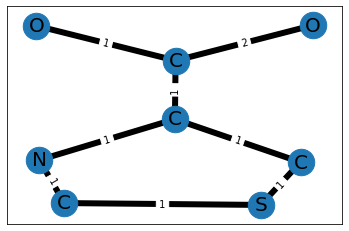

In [ ]:

Graph = nx.read_gexf('AIDS700nef/test/1011.gexf',version='1.2draft')
draw_graph(Graph)

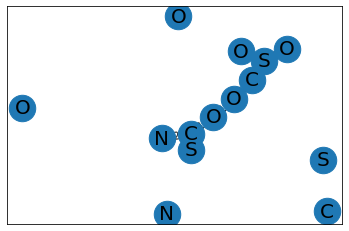

In [ ]:

Graph = nx.read_gexf('AIDS700nef/test/1011_new.gexf',version='1.2draft')
draw_graph(Graph)